In [1]:
#importacion de las bibliotecas de Keras y librerias de Keras

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


2023-11-28 17:00:43.682161: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-28 17:00:43.682215: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-28 17:00:43.682252: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-28 17:00:43.690889: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1


2023-11-28 17:00:45.443254: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-28 17:00:45.447994: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-28 17:00:45.448158: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [38]:
# importacion del set de entrenamiento
horas_para_LSTM = 120 #cantidad de dias que se toman para predecir el siguiente/horas hacia atras
dataset_train_sinFiltrar = pd.read_csv('Weather_Valencia_Train_2015-2017.csv')
longitudArchivoTrain = len(dataset_train_sinFiltrar)
print("longitudArchivoTrain: ", longitudArchivoTrain)

longitudArchivoTrain:  26366


In [39]:
#filtracion de las columnas que me interesan
dataset_train =dataset_train_sinFiltrar.iloc[:, 2:3]
print(dataset_train)
training_set = dataset_train.values

          temp
0      270.475
1      270.475
2      269.686
3      269.686
4      269.686
...        ...
26361  290.150
26362  290.150
26363  289.150
26364  290.150
26365  289.150

[26366 rows x 1 columns]


In [40]:
# Escalado de caracteristicas

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1)) # normalizacion de los datos
training_set_scaled = sc.fit_transform(training_set)


In [43]:
#Creación de una estructura de datos con 120 (equivale a 5 dias previos) pasos de tiempo y 1 salida
X_train = []
y_train = []
for i in range(horas_para_LSTM, longitudArchivoTrain): #lee a partir  de la fila 120 hasta la cantidad de filas del dataset (26366)
    X_train.append(training_set_scaled[i-horas_para_LSTM:i, 0])  #para mi aca no va 0 
    y_train.append(training_set_scaled[i, 0]) #para mi aca no va 0
X_train, y_train = np.array(X_train), np.array(y_train) #los transforma en np.array

In [44]:
#Remodelación

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) ##aca para meterle mas parametros al tensor


In [45]:
#Importación de las librerías y paquetes Keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout


In [46]:
#Inicializando el RNN

regressor = Sequential()

#Añadiendo la primera capa de LSTM y algo de regularización de la deserción

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

#Añadiendo la segunda capa de LSTM y algo de regularización de la deserción

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

#Añadiendo la tercera capa de LSTM y algo de regularización de la deserción

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
#Añadiendo la cuarta capa de LSTM y algo de regularización de la deserción
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

#Añadiendo la capa de salida

regressor.add(Dense(units = 1))

In [49]:
#Compilación del RNN

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

#Ajustar el RNN al set de entrenamiento
epocas = 2
regressor.fit(X_train, y_train, epochs = epocas, batch_size = 32)

Epoch 1/2
821/821 [==============================] - 22s 21ms/step - loss: 0.0023
Epoch 2/2
821/821 [==============================] - 17s 21ms/step - loss: 0.0016


In [62]:
#Obtención del clima
horas_a_predecir = 50 #cantidad de horas a predecir
dataset_test = pd.read_csv('Weather_Valencia_Test_2018.csv')
real_weather_temp = dataset_test.iloc[:, 2:3].values

#Obtención del precio de las acciones previsto para 2017

dataset_total = pd.concat((dataset_train['temp'], dataset_test['temp']), axis = 0) #concatena los datos de entrenamiento y los de test
inputs = dataset_total[len(dataset_total) - len(dataset_test) - horas_para_LSTM:].values #toma los ultimos 120 HORAS del 2016
inputs = inputs.reshape(-1,1) #transforma los datos en un array de 1 columna
inputs = sc.transform(inputs) #normaliza los datos
X_test = [] #crea un array vacio
for i in range(120, 8780): #toma los ultimos 120 dias del 2016 8780
    X_test.append(inputs[i-horas_para_LSTM:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#print(X_test)
#print(X_test.shape)
predicted_weather_temp = regressor.predict(X_test)
predicted_weather_temp = sc.inverse_transform(predicted_weather_temp)


271/271 [==============================] - 2s 8ms/step


In [63]:
#Obtención del clima TODO ARTIFICIAL

horas_a_predecir = 50 #cantidad de horas a predecir

#Obtención del precio de las acciones previsto para 2017

dataset_total = dataset_train['temp'] #concatena los datos de entrenamiento y los de test
inputs = dataset_total[len(dataset_total) - horas_para_LSTM:].values #toma los ultimos 120 HORAS del 2016
inputs = inputs.reshape(-1,1) #transforma los datos en un array de 1 columna
#print(inputs)

inputs = sc.transform(inputs) #normaliza los datos

inputs_arreglados = np.array(inputs)
inputs_arreglados = np.reshape(inputs, (inputs.shape[0], inputs.shape[1], 1))

#array_transformado = np.transpose(inputs_arreglados, (1, 0))  # (1, 120, 1)

print(inputs_arreglados)
print(inputs_arreglados.shape)

X_test_artificial = [] #crea un array vacio


for i in range(120, 8780): #toma los ultimos 120 dias del 2016 8780    
    predicted_weather_temp_artificial = regressor.predict(inputs_arreglados)
    inputs_arreglados = np.append(inputs_arreglados, predicted_weather_temp_artificial)    
    X_test_artificial.append(inputs)

#print(inputs_arreglados)
#print(inputs_arreglados.shape)

#predicted_weather_temp = regressor.predict(X_test)
#predicted_weather_temp = sc.inverse_transform(predicted_weather_temp)

[[[0.36199389]]

 [[0.38562374]]

 [[0.38562374]]

 [[0.4092536 ]]

 [[0.4092536 ]]

 [[0.4092536 ]]

 [[0.4092536 ]]

 [[0.43288346]]

 [[0.43288346]]

 [[0.36199389]]

 [[0.43288346]]

 [[0.45651331]]

 [[0.45651331]]

 [[0.48014317]]

 [[0.50377302]]

 [[0.50377302]]

 [[0.50377302]]

 [[0.48014317]]

 [[0.48014317]]

 [[0.43288346]]

 [[0.43288346]]

 [[0.43288346]]

 [[0.38562374]]

 [[0.38562374]]

 [[0.38562374]]

 [[0.38562374]]

 [[0.38562374]]

 [[0.38562374]]

 [[0.38562374]]

 [[0.36199389]]

 [[0.36199389]]

 [[0.36199389]]

 [[0.36199389]]

 [[0.36199389]]

 [[0.4092536 ]]

 [[0.43288346]]

 [[0.50377302]]

 [[0.52740288]]

 [[0.55103274]]

 [[0.57466259]]

 [[0.59829245]]

 [[0.57466259]]

 [[0.57466259]]

 [[0.50377302]]

 [[0.48014317]]

 [[0.50377302]]

 [[0.43288346]]

 [[0.45651331]]

 [[0.48014317]]

 [[0.4092536 ]]

 [[0.38562374]]

 [[0.33836403]]

 [[0.38562374]]

 [[0.36199389]]

 [[0.33836403]]

 [[0.29110432]]

 [[0.29110432]]

 [[0.29110432]]

 [[0.4092536 ]

TypeError: in user code:

    File "/home/mikel/Documents/Facultad/IA/IA/lib/python3.10/site-packages/keras/src/engine/training.py", line 2416, in predict_function  *
        return step_function(self, iterator)
    File "/home/mikel/Documents/Facultad/IA/IA/lib/python3.10/site-packages/keras/src/engine/training.py", line 2401, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/mikel/Documents/Facultad/IA/IA/lib/python3.10/site-packages/keras/src/engine/training.py", line 2389, in run_step  **
        outputs = model.predict_step(data)
    File "/home/mikel/Documents/Facultad/IA/IA/lib/python3.10/site-packages/keras/src/engine/training.py", line 2357, in predict_step
        return self(x, training=False)
    File "/home/mikel/Documents/Facultad/IA/IA/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/mikel/Documents/Facultad/IA/IA/lib/python3.10/site-packages/keras/src/layers/rnn/lstm.py", line 616, in call
        timesteps = input_shape[0] if self.time_major else input_shape[1]

    TypeError: Exception encountered when calling layer 'lstm_8' (type LSTM).
    
    'NoneType' object is not subscriptable
    
    Call arguments received by layer 'lstm_8' (type LSTM):
      • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
      • mask=None
      • training=False
      • initial_state=None


(50,)
(50, 1)
(50, 1)
(50, 1)


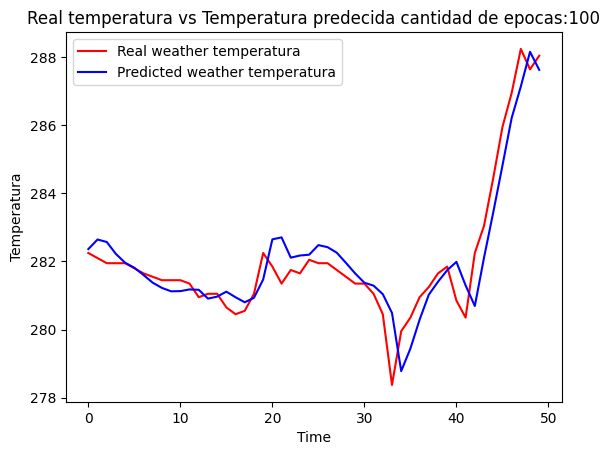

IndexError: index 50 is out of bounds for axis 0 with size 50

In [ ]:
xgrafico = np.arange(0, horas_a_predecir, 1)
print(xgrafico.shape)
print(real_weather_temp.shape)
real_weather_temp = real_weather_temp[:horas_a_predecir]
print(real_weather_temp.shape)
print(predicted_weather_temp.shape)

plt.plot(real_weather_temp, color = 'red', label = 'Real weather temperatura')
plt.plot(predicted_weather_temp, color = 'blue', label = 'Predicted weather temperatura')
#plt.figure(figsize=(20,100))
#plt.scatter(xgrafico,real_weather_temp, color = 'red', label = 'Real weather temperatura',s=1)
#plt.scatter(xgrafico,predicted_weather_temp, color = 'blue', label = 'Predicted weather temperatura',s=1)
plt.title('Real temperatura vs Temperatura predecida cantidad de epocas:'+str(epocas) ) 
plt.xlabel('Time')
plt.ylabel('Temperatura')
plt.legend()
plt.show()

print(real_weather_temp[50])
print(predicted_weather_temp[50])
